In [ ]:
!pip install --upgrade derivative
!pip install scikit-learn==1.0.2
import os
os.kill(os.getpid(), 9)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 9.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install pysindy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 KB 5.0 MB/s eta 0:00:00


**Modello SIR**

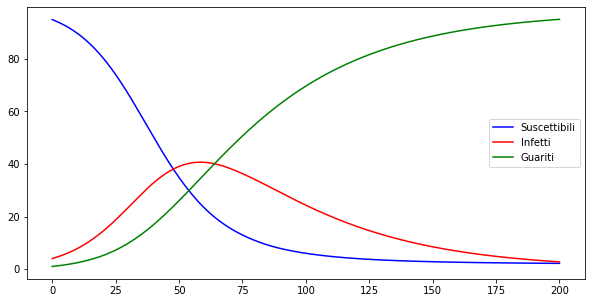

In [6]:
import numpy as np
from scipy.integrate import solve_ivp
import pysindy as ps
import matplotlib.pyplot as plt
from pysindy import SINDy
from sklearn.linear_model import Lasso
from matplotlib.cm import rainbow

def SIR(t, y, beta, gamma):
    S, I, R = y
    N = S + I + R
    dSdt = -(beta * S * I)/ N
    dIdt = (beta * S * I)/ N - gamma * I
    dRdt = gamma*I
    return [dSdt, dIdt, dRdt]

beta = 0.1 #tasso di infezione
gamma = 0.025 #tasso di recupero
S0 = 95
I0 = 4
R0 = 1
t_span=[0,200]
y0 = [S0, I0, R0]
sol = solve_ivp(SIR, t_span, y0, args=(beta, gamma), dense_output=True)

dt = 0.01
t = np.arange(t_span[0], t_span[1], dt)
y = sol.sol(t)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(t,y[0,:],"b")
ax.plot(t,y[1,:],"r")
ax.plot(t,y[2,:],"g")
plt.legend(['Suscettibili','Infetti','Guariti'])
plt.show()

(S)' = -0.001 S I
(I)' = 0.001 S I
(R)' = 0.000


<ipython-input-7-345705fed532>:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1) # row 1, col 2 index 1


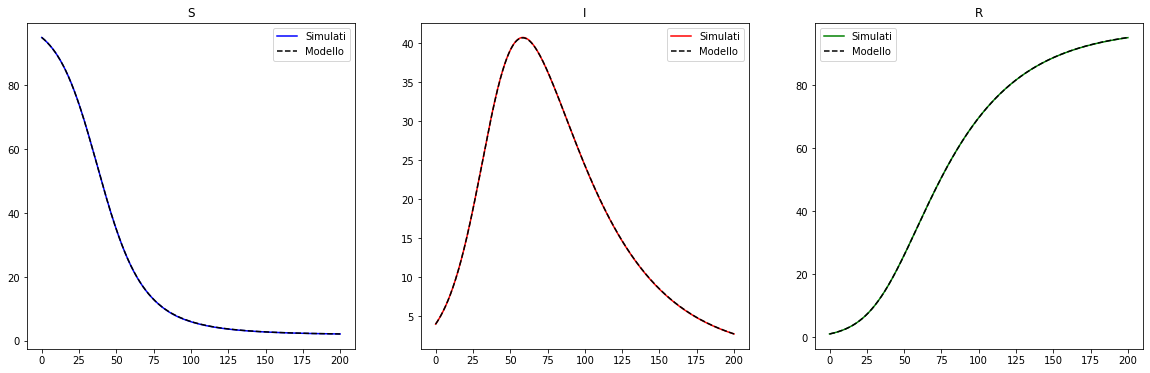

S': -0.001002 * S I
I': 0.000750 * S I + -0.000247 * I^2 + -0.000250 * I R
R': 0.000250 * S I + 0.000249 * I^2 + 0.000250 * I R


In [7]:
s=y[0,:]
i=y[1,:]
r=y[2,:]
X = np.stack((s, i,r),axis=-1)

threshold = 1e-4
poly_order = 2

# Inizializza l'oggetto SINDy con il valore di sparsity impostato a 0.1
model = SINDy(optimizer=ps.STLSQ(threshold=threshold),feature_library = ps.PolynomialLibrary(degree=poly_order),feature_names=["S","I","R"])

model.fit(X,t=t)
model.print()

x0_train=y0
t_train=t
x_train=X

x_sim = model.simulate(x0_train, t_train)

fig = plt.subplots(figsize=(20,6))
plt.subplot(1, 3, 1) # row 1, col 2 index 1
plt.plot(t,y[0,:],"b")
plt.plot(t,x_sim[:,0],"k--")
plt.title("S")
plt.legend(['Simulati','Modello'])

plt.subplot(1, 3, 2) # row 1, col 2 index 1
plt.plot(t,y[1,:],"r")
plt.plot(t,x_sim[:,1],"k--")
plt.title("I")
plt.legend(['Simulati','Modello'])

plt.subplot(1, 3, 3) # row 1, col 2 index 1
plt.plot(t,y[2,:],"g")
plt.plot(t,x_sim[:,2],"k--")
plt.title("R")
plt.legend(['Simulati','Modello'])

plt.show()

feature_names = model.feature_library.get_feature_names()
coefficients = model.coefficients()
var = model.feature_names
feature_names = [f.replace('x0', 'S').replace('x1', 'I').replace('x2', 'R') for f in feature_names]

# print the equation
for i in range(len(coefficients)):
    equation = ''
    for j in range(len(feature_names)):
        coefficient = coefficients[i, j]
        if coefficient != 0:
            variable = feature_names[j]
            if equation != '':
                equation += ' + '
            equation += f'{coefficient:.6f} * {variable}'
    print(f"{(var[i])}': {equation}")

In [20]:
# Generate training data
x0_train=y0
t_train=t
x_train=X
x_dot_train_measured = np.array([SIR(t_train,x_train[i],beta,gamma) for i in range(t_train.size)])

threshold = 1e-4
poly_order = 2

noise_levels = [1e-2, 1e-1, 1, 1e1]

models = []
t_span_sim=[0,100]
t_sim = np.arange(t_span_sim[0], t_span_sim[1], dt)
x_sim = []
for eps in noise_levels:
    model = SINDy(optimizer=ps.STLSQ(threshold=threshold), feature_library = ps.PolynomialLibrary(degree=poly_order), feature_names=["S","I","R"])
    model.fit(x_train, t=dt, x_dot=x_dot_train_measured + np.random.normal(scale=eps, size=x_train.shape), quiet=True)
    models.append(model)
    x_sim.append(model.simulate(x_train[0], t_sim))

In [22]:
print(models[0].equations())
print(models[1].equations())
print(models[2].equations())
print(models[3].equations())

['-0.001 S I', '0.001 S I', '0.000']
['-0.001 S I', '0.001 S I', '0.000']
['-0.001 S I', '0.001 S I', '0.000']
['-0.001 S I + -0.001 S R', '-0.006 S I + 0.019 S R + -0.004 I^2 + -0.002 I R', '0.001 S I + -0.002 S R + 0.001 I R']


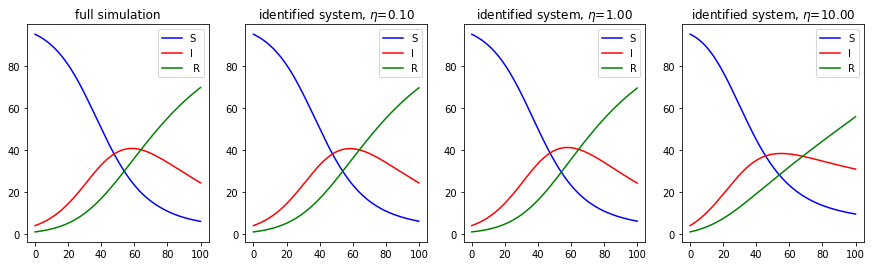

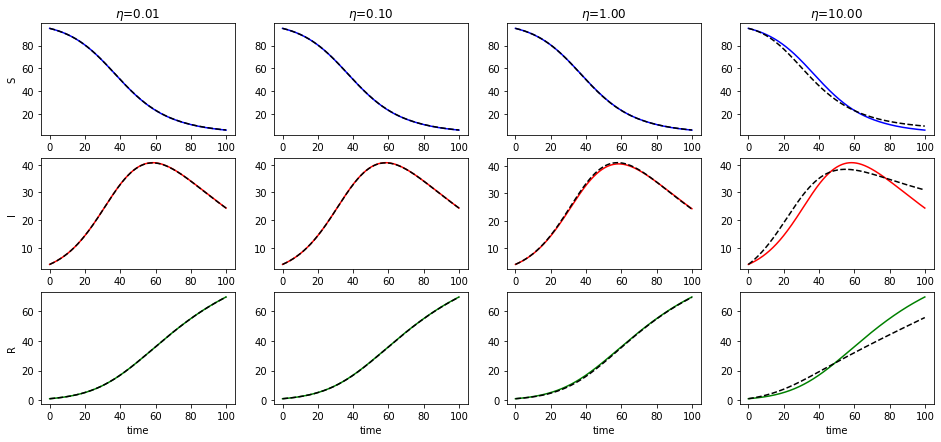

In [23]:
# Plot results

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(141)
ax.plot(t_sim,x_train[: t_sim.size, 0],"b")
ax.plot(t_sim,x_train[: t_sim.size, 1],"r")
ax.plot(t_sim,x_train[: t_sim.size, 2],"g")
plt.title("full simulation")
plt.legend(['S','I',' R'])

model_idx = 1
ax = fig.add_subplot(142)
ax.plot(t_sim,x_sim[model_idx][:, 0],"b")
ax.plot(t_sim,x_sim[model_idx][:, 1],"r")
ax.plot(t_sim,x_sim[model_idx][:, 2],"g")
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
plt.legend(['S','I','R'])

model_idx = 2
ax = fig.add_subplot(143)
ax.plot(t_sim,x_sim[model_idx][:, 0],"b")
ax.plot(t_sim,x_sim[model_idx][:, 1],"r")
ax.plot(t_sim,x_sim[model_idx][:, 2],"g")
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
plt.legend(['S','I','R'])

model_idx = 3
ax = fig.add_subplot(144)
ax.plot(t_sim,x_sim[model_idx][:, 0],"b")
ax.plot(t_sim,x_sim[model_idx][:, 1],"r")
ax.plot(t_sim,x_sim[model_idx][:, 2],"g")
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
plt.legend(['S','I','R'])

fig = plt.figure(figsize=(16, 7))
model_idx = 0
ax = fig.add_subplot(341)
ax.plot(t_sim, x_train[: t_sim.size, 0], "b")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("S")

ax = fig.add_subplot(345)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim[model_idx][:, 1], "k--")
plt.ylabel("I")

ax = fig.add_subplot(349)
ax.plot(t_sim, x_train[: t_sim.size, 2], "g")
ax.plot(t_sim, x_sim[model_idx][:, 2], "k--")
plt.xlabel("time")
plt.ylabel("R")

model_idx = 1
ax = fig.add_subplot(342)
ax.plot(t_sim, x_train[: t_sim.size, 0], "b")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")

ax = fig.add_subplot(346)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim[model_idx][:, 1], "k--")

ax = fig.add_subplot(3,4,10)
ax.plot(t_sim, x_train[: t_sim.size, 2], "g")
ax.plot(t_sim, x_sim[model_idx][:, 2], "k--")
plt.xlabel("time")

model_idx = 2
ax = fig.add_subplot(343)
ax.plot(t_sim, x_train[: t_sim.size, 0], "b")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")

ax = fig.add_subplot(347)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim[model_idx][:, 1], "k--")

ax = fig.add_subplot(3,4,11)
ax.plot(t_sim, x_train[: t_sim.size, 2], "g")
ax.plot(t_sim, x_sim[model_idx][:, 2], "k--")
plt.xlabel("time")

model_idx = 3
ax = fig.add_subplot(344)
ax.plot(t_sim, x_train[: t_sim.size, 0], "b")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")

ax = fig.add_subplot(348)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim[model_idx][:, 1], "k--")

ax = fig.add_subplot(3,4,12)
ax.plot(t_sim, x_train[: t_sim.size, 2], "g")
ax.plot(t_sim, x_sim[model_idx][:, 2], "k--")
plt.xlabel("time")


fig.show()

In [24]:
# Fit the models and simulate

noise_levels = [1e-2, 1e-1, 1, 1e1]

models_noD = []
t_sim = np.arange(0,100, dt)
x_sim_noD = []
for eps in noise_levels:
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold),
        feature_library=ps.PolynomialLibrary(degree=poly_order),
    )
    model.fit(x_train + np.random.normal(scale=eps, size=x_train.shape), 
              t=dt,quiet=True)
    models_noD.append(model)
    x_sim_noD.append(model.simulate(x_train[0], t_sim))

In [25]:
print(models_noD[0].equations())
print(models_noD[1].equations())
print(models_noD[2].equations())
print(models_noD[3].equations())

['-51788.821 1 + 1035.080 x0 + 1035.132 x1 + 1036.186 x2 + -5.172 x0^2 + -10.345 x0 x1 + -10.355 x0 x2 + -5.172 x1^2 + -10.355 x1 x2 + -5.183 x2^2', '71052.077 1 + -1420.805 x0 + -1419.716 x1 + -1421.388 x2 + 7.103 x0^2 + 14.196 x0 x1 + 14.211 x0 x2 + 7.092 x1^2 + 14.200 x1 x2 + 7.109 x2^2', '-130509.736 1 + 2610.688 x0 + 2609.549 x1 + 2610.097 x2 + -13.056 x0^2 + -26.100 x0 x1 + -26.105 x0 x2 + -13.044 x1^2 + -26.094 x1 x2 + -13.050 x2^2']
['2524.022 1 + -51.199 x0 + -49.552 x1 + -50.189 x2 + 0.260 x0^2 + 0.501 x0 x1 + 0.511 x0 x2 + 0.243 x1^2 + 0.492 x1 x2 + 0.249 x2^2', '3453.466 1 + -68.671 x0 + -70.930 x1 + -68.748 x2 + 0.341 x0^2 + 0.703 x0 x1 + 0.691 x0 x2 + 0.362 x1^2 + 0.705 x1 x2 + 0.342 x2^2', '215.267 1 + -3.392 x0 + -4.081 x1 + -4.381 x2 + 0.012 x0^2 + 0.029 x0 x1 + 0.042 x0 x2 + 0.018 x1^2 + 0.041 x1 x2 + 0.022 x2^2']
['70.143 1 + -1.562 x0 + 0.606 x1 + -2.087 x2 + 0.009 x0^2 + -0.003 x0 x1 + 0.018 x0 x2 + -0.013 x1^2 + 0.001 x1 x2 + 0.014 x2^2', '-1829.634 1 + 38.097 x0 

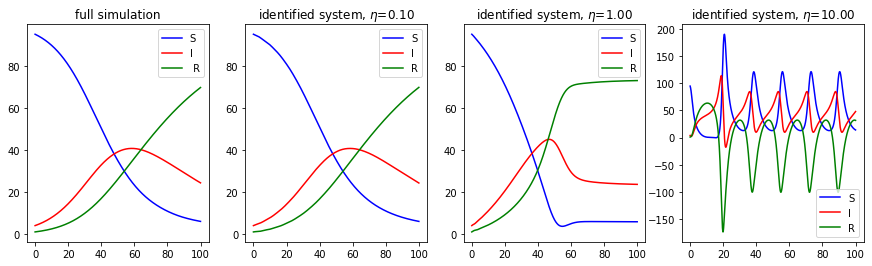

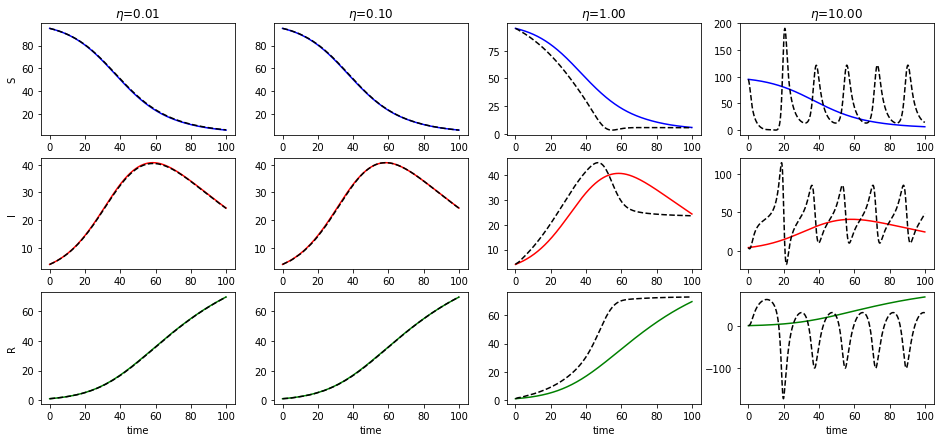

In [26]:
# Plot results

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(141)
ax.plot(t_sim,x_train[: t_sim.size, 0],"b")
ax.plot(t_sim,x_train[: t_sim.size, 1],"r")
ax.plot(t_sim,x_train[: t_sim.size, 2],"g")
plt.title("full simulation")
plt.legend(['S','I',' R'])

model_idx = 1
ax = fig.add_subplot(142)
ax.plot(t_sim,x_sim_noD[model_idx][:, 0],"b")
ax.plot(t_sim,x_sim_noD[model_idx][:, 1],"r")
ax.plot(t_sim,x_sim_noD[model_idx][:, 2],"g")
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
plt.legend(['S','I','R'])

model_idx = 2
ax = fig.add_subplot(143)
ax.plot(t_sim,x_sim_noD[model_idx][:, 0],"b")
ax.plot(t_sim,x_sim_noD[model_idx][:, 1],"r")
ax.plot(t_sim,x_sim_noD[model_idx][:, 2],"g")
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
plt.legend(['S','I','R'])

model_idx = 3
ax = fig.add_subplot(144)
ax.plot(t_sim,x_sim_noD[model_idx][:, 0],"b")
ax.plot(t_sim,x_sim_noD[model_idx][:, 1],"r")
ax.plot(t_sim,x_sim_noD[model_idx][:, 2],"g")
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
plt.legend(['S','I','R'])

fig = plt.figure(figsize=(16, 7))
model_idx = 0
ax = fig.add_subplot(341)
ax.plot(t_sim, x_train[: t_sim.size, 0], "b")
ax.plot(t_sim, x_sim_noD[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("S")

ax = fig.add_subplot(345)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim_noD[model_idx][:, 1], "k--")
plt.ylabel("I")

ax = fig.add_subplot(349)
ax.plot(t_sim, x_train[: t_sim.size, 2], "g")
ax.plot(t_sim, x_sim_noD[model_idx][:, 2], "k--")
plt.xlabel("time")
plt.ylabel("R")

model_idx = 1
ax = fig.add_subplot(342)
ax.plot(t_sim, x_train[: t_sim.size, 0], "b")
ax.plot(t_sim, x_sim_noD[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")

ax = fig.add_subplot(346)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim_noD[model_idx][:, 1], "k--")

ax = fig.add_subplot(3,4,10)
ax.plot(t_sim, x_train[: t_sim.size, 2], "g")
ax.plot(t_sim, x_sim_noD[model_idx][:, 2], "k--")
plt.xlabel("time")

model_idx = 2
ax = fig.add_subplot(343)
ax.plot(t_sim, x_train[: t_sim.size, 0], "b")
ax.plot(t_sim, x_sim_noD[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")

ax = fig.add_subplot(347)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim_noD[model_idx][:, 1], "k--")

ax = fig.add_subplot(3,4,11)
ax.plot(t_sim, x_train[: t_sim.size, 2], "g")
ax.plot(t_sim, x_sim_noD[model_idx][:, 2], "k--")
plt.xlabel("time")

model_idx = 3
ax = fig.add_subplot(344)
ax.plot(t_sim, x_train[: t_sim.size, 0], "b")
ax.plot(t_sim, x_sim_noD[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")

ax = fig.add_subplot(348)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim_noD[model_idx][:, 1], "k--")

ax = fig.add_subplot(3,4,12)
ax.plot(t_sim, x_train[: t_sim.size, 2], "g")
ax.plot(t_sim, x_sim_noD[model_idx][:, 2], "k--")
plt.xlabel("time")


fig.show()

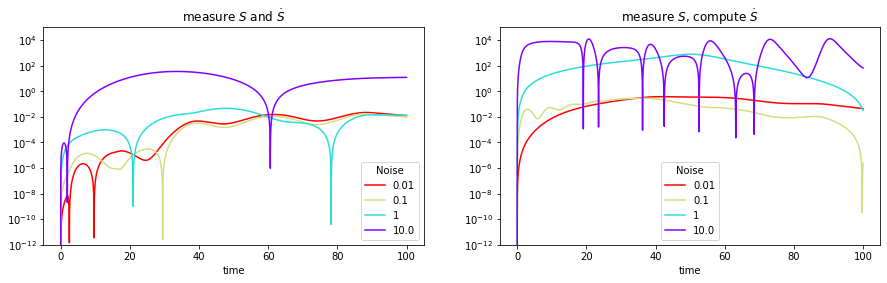

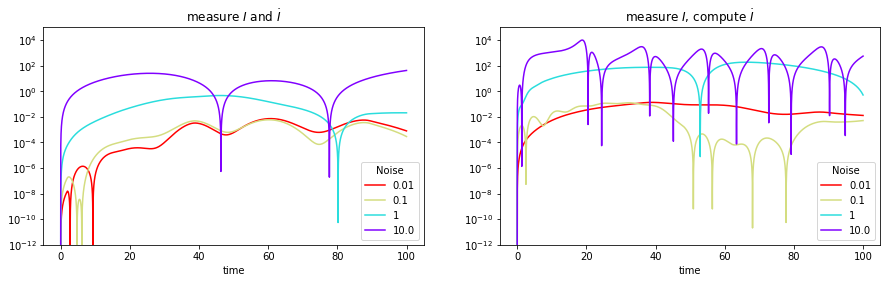

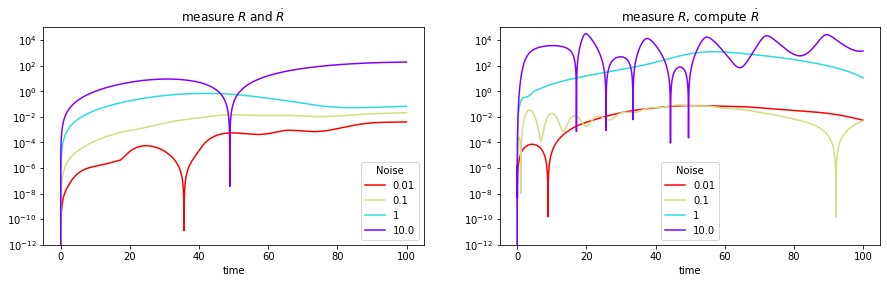

In [27]:
colors = rainbow(np.linspace(1, 0, len(models)))

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
for i, x in enumerate(x_sim):
    axs[0].semilogy(
        t_sim,
        ((x - x_train[: t_sim.size]) ** 2)[:,0],
        color=colors[i],
        label=noise_levels[i],
    )
axs[0].set(xlabel="time", title="measure $S$ and $\dot{S}$")
axs[0].legend(title="Noise")
axs[0].set_ylim(1e-12, 1e5)

for i, x in enumerate(x_sim_noD):
    axs[1].semilogy(
        t_sim,
        ((x - x_train[: t_sim.size]) ** 2)[:,0],
        color=colors[i],
        label=noise_levels[i],
    )

axs[1].set(xlabel="time", title="measure $S$, compute $\dot{S}$")
axs[1].legend(title="Noise")
axs[1].set_ylim(1e-12, 1e5)

fig.show()


fig, axs = plt.subplots(1, 2, figsize=(15, 4))
for i, x in enumerate(x_sim):
    axs[0].semilogy(
        t_sim,
        ((x - x_train[: t_sim.size]) ** 2)[:,1],
        color=colors[i],
        label=noise_levels[i],
    )
axs[0].set(xlabel="time", title="measure $I$ and $\dot{I}$")
axs[0].legend(title="Noise")
axs[0].set_ylim(1e-12, 1e5)


for i, x in enumerate(x_sim_noD):
    axs[1].semilogy(
        t_sim,
        ((x - x_train[: t_sim.size]) ** 2)[:,1],
        color=colors[i],
        label=noise_levels[i],
    )

axs[1].set(xlabel="time", title="measure $I$, compute $\dot{I}$")
axs[1].legend(title="Noise")
axs[1].set_ylim(1e-12, 1e5)
fig.show()


fig, axs = plt.subplots(1, 2, figsize=(15, 4))
for i, x in enumerate(x_sim):
    axs[0].semilogy(
        t_sim,
        ((x - x_train[: t_sim.size]) ** 2)[:,2],
        color=colors[i],
        label=noise_levels[i],
    )
axs[0].set(xlabel="time", title="measure $R$ and $\dot{R}$")
axs[0].legend(title="Noise")
axs[0].set_ylim(1e-12, 1e5)

for i, x in enumerate(x_sim_noD):
    axs[1].semilogy(
        t_sim,
        ((x - x_train[: t_sim.size]) ** 2)[:,2],
        color=colors[i],
        label=noise_levels[i],
    )

axs[1].set(xlabel="time", title="measure $R$, compute $\dot{R}$")
axs[1].legend(title="Noise")
axs[1].set_ylim(1e-12, 1e5)

fig.show()